In [1]:
from collections import deque
from heapq import heappush, heappop
import math
import torch
from torch.utils.data import DataLoader

from hbo_bench.oracle import Oracle, OracleRequest
from hbo_bench.utils import get_cardinalities, get_selectivities, MAX_TREE_LENGTH, get_full_plan, preprocess
from hbo_bench.vectorization import extract_vertices_and_edges, ALL_OPERATIONS
from hbo_bench.dataset import WeightedBinaryTreeDataset, weighted_binary_tree_collate
from hbo_bench.data_config import DEFAULT_DOP, DEFAULT_HINTSET, HINTSETS, DOPS
from hbo_bench.query_explorer import QueryExplorer, SearchingSettings, SearchingState
from hbo_bench.local_search_settings import PRUNED_LOCAL_SS, PRUNED_LOCAL_DEF_DOP_SS, GREEDY_SS, EMPTY_SS, ALL_SS, ALL_DEF_DOP_SS

# Oracle

An *oracle* in math is some object that allows to get answers to some questions **without any computational cost**. In our case, the oracle will answer for each of the queries (and each set of parameters) on the questions:
- *What is the* [`plan` / `planning_time` / `execution_time`] *of that query with applying such parameters?*

In [3]:
tpch_oracle = Oracle("data/processed/tpch_10gb")

In [4]:
plan = tpch_oracle.get_explain_plan(OracleRequest(query_name="q01", hintset=0, dop=1))
print("Plan for query 'q01' with hintset=0 and dop=1 is:")
plan.model_dump()

Plan for query 'q01' with hintset=0 and dop=1 is:


{'plan': {'node_type': 'Sort',
  'plans': [{'node_type': 'Aggregate',
    'plans': [{'node_type': 'Seq Scan',
      'plans': [],
      'estimated_cardinality': 58767934,
      'index_name': None,
      'relation_name': 'lineitem',
      'cost': 2165082.91}],
    'estimated_cardinality': 6,
    'index_name': None,
    'relation_name': None,
    'cost': 4515800.38}],
  'estimated_cardinality': 6,
  'index_name': None,
  'relation_name': None,
  'cost': 4515800.47},
 'template_id': 177413717,
 'planning_time': 0.0}

# Feature extraction

Node cardinality is actually the value of the `estimated_cardinality` field, and `selectivity` is the fraction of tuples that were selected during filtering. It is computed in general as the ratio of the cardinality of the parent to the product of the cardinality of the children. We collect vectors of these statistics by left-first in-order plan traversal.

In [5]:
assert get_cardinalities(plan) == [6, 6, 58767934]
# for simplicity we calculate cardinality instead of selectivity for leaf nodes
assert get_selectivities(plan) == [1.0, 6/58767934, float(58767934)]

# Encoding

In order to vectorise the tree, we use the following encoding scheme.

We collect all 25 operators (occurring in the plans from `JOB` and `sample_queries` benchmarks), and use one-hot encoding to encode them. We then extend it with two values of statistics -- `math.log(cardinality)` and `selectivity`.

In [6]:
vertices, edges = extract_vertices_and_edges(plan)
time = torch.Tensor([1.0])
sort_index = ALL_OPERATIONS.index("Sort")
assert vertices.shape[1] == len(ALL_OPERATIONS) + 2
assert torch.all(vertices[0][0:sort_index] == 0) and torch.all(vertices[0][sort_index+1:-2] == 0)
assert vertices[0][sort_index] == 1.0
assert vertices[0][-1] == 1.0
assert vertices[0][-2] == math.log(6.0)

# Dataset

To form a efficient dataset from a vectorised representation of trees, we store **only unique** trees, describing them by the number of repetitions and average execution time.

In [7]:
freq = 42
dataset = WeightedBinaryTreeDataset([vertices] * freq, [edges] * freq, [time] * freq, torch.device("cpu"))
for v, e, f, t in dataset:
    assert torch.all(v - vertices == 0)
    assert torch.all(e - edges == 0)
    assert torch.all(t - time == 0)
    assert torch.all(f - torch.Tensor([freq]) == 0)
assert len(dataset) == 1

# Dataloader

The key to creating a right dataloader is that we change the order of the axes. The first channels should be those related to the dimensionality of the vector representation of nodes (so-called *channels*), and the tree is represented by a sequence (of arbitrary length) of such vectors (see `weighted_binary_tree_collate` or `preprocess` for implementation).

In [8]:
freq = 42
plan = tpch_oracle.get_explain_plan(OracleRequest(query_name="q01", hintset=0, dop=1))
(vertices, edges), time = extract_vertices_and_edges(plan), torch.Tensor([1.0])
dataset = WeightedBinaryTreeDataset([vertices] * freq, [edges] * freq, [time] * freq, torch.device("cpu"))
assert len(dataset) == 1

dataloader = DataLoader(
    dataset=dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=lambda el: weighted_binary_tree_collate(el, MAX_TREE_LENGTH),
    drop_last=False,
)

vertices, edges = preprocess(vertices, edges)
for (v, e, f), t in dataloader:
    assert torch.all(v[0] - vertices == 0)
    assert torch.all(e[0] - edges == 0)
    assert torch.all(t[0] - time == 0)
    assert torch.all(f[0] - torch.Tensor([freq]) == 0)


# Hint based optimisation

The main advantage of data from that project (and the presented functionality over them) is that we can test the feasibility of applying hint based optimisation **without having to actually execute queries**! This allows us to go through **thousands** of different configurations of the search algorithm and quickly test different hypotheses.

An example of fast checking the possibilities of hint based optimisation on `TPCH` benchmark.

P.S. *Note that this is the **most inconvenient** benchmark for optimisation, because almost all modern RDBMSs are overfitted for it*

In [9]:
print("Query | Default Time (s) | Best Time (s) | Best Params (hs, dop)")

total_default_time, total_with_best_parameters_time = 0, 0

for query_name in sorted(tpch_oracle.get_query_names()):
    def_request = OracleRequest(query_name=query_name, hintset=DEFAULT_HINTSET, dop=DEFAULT_DOP)
    default_time = tpch_oracle.get_planning_time(def_request) + tpch_oracle.get_execution_time(def_request)
    
    best_params = min(
        ((hintset, dop) for hintset in HINTSETS for dop in DOPS),
        key=lambda params: (
            tpch_oracle.get_planning_time(OracleRequest(query_name=query_name, hintset=params[0], dop=params[1])) +
            tpch_oracle.get_execution_time(OracleRequest(query_name=query_name, hintset=params[0], dop=params[1]))
        )
    )
    
    with_best_parameters_time = (
        tpch_oracle.get_planning_time(OracleRequest(query_name=query_name, hintset=best_params[0], dop=best_params[1])) +
        tpch_oracle.get_execution_time(OracleRequest(query_name=query_name, hintset=best_params[0], dop=best_params[1]))
    )

    print(f"{query_name} | {default_time / 1000:0.2f} | {with_best_parameters_time/1000:0.2f} | {best_params}")

Query | Default Time (s) | Best Time (s) | Best Params (hs, dop)
q01 | 131.01 | 129.74 | (0, 1)
q02 | 32.22 | 12.72 | (16, 1)
q03 | 1.76 | 1.74 | (89, 64)
q04 | 1.99 | 1.99 | (8, 64)
q05 | 2.80 | 2.80 | (8, 64)
q06 | 3.97 | 3.81 | (0, 1)
q07 | 11.27 | 10.85 | (33, 1)
q08 | 4.52 | 1.23 | (8, 16)
q09 | 1.24 | 1.13 | (32, 1)
q10 | 54.87 | 49.55 | (35, 1)
q11 | 23.95 | 2.30 | (1, 1)
q12 | 1.34 | 1.26 | (40, 64)
q13 | 76.82 | 25.15 | (96, 16)
q14 | 12.91 | 6.88 | (98, 64)
q15 | 3.88 | 3.88 | (8, 64)
q16 | 20.95 | 20.95 | (32, 64)
q17 | 23.80 | 4.74 | (16, 64)
q18 | 15.46 | 9.91 | (38, 64)
q19 | 4.44 | 4.25 | (0, 1)
q20 | 19.91 | 19.77 | (41, 1)
q21 | 6.87 | 6.03 | (80, 1)
q22 | 58.98 | 55.37 | (16, 16)


We see that applying hints can significantly speed up queries (`q11`, `q13`, `q17`, etc.).

# Query Exploration Strategies

Instead of using an exhaustive search algorithm to find the best parameters, we can use **local search algorithms**. The simplest example is shown below.

In [10]:
def emulate_exhaustive_paralell_search(oracle: "Oracle", query_name: "QueryName", searching_settings: "SearchingSettings") -> "Tuple[SerachingState, Time]":
    
    def _prepare_request(state: "SearchingState") -> "OracleRequest":
        return OracleRequest(query_name=query_name, hintset=state.hintset, dop=state.dop)

    threads = [0.0 for _ in searching_settings.hardcoded_dops]
    
    queue = deque(
        [SearchingState(hs, dop) for hs in searching_settings.hardcoded_hintsets for dop in searching_settings.hardcoded_dops]
    )
    seen_plans = set()

    def_state = SearchingState(searching_settings.default_hintset, searching_settings.default_dop)
    record_state, record_time = def_state, float("inf")
    last_time = 0.0
    
    while queue:
        st = deque.popleft(queue)
        time = heappop(threads)
        plan, plan_time = get_full_plan(oracle.get_explain_plan(_prepare_request(st))), oracle.get_planning_time(_prepare_request(st)) / 1000
        time += plan_time
        ex_time = oracle.get_execution_time(_prepare_request(st)) / 1000
        # optimisations: use timeout and avoiding the re-execution of duplacates
        time += min(ex_time, record_time) * (plan not in seen_plans)
        seen_plans.add(plan)    
        if plan_time + ex_time < record_time:
            record_state, record_time = st, plan_time + ex_time
        last_time = max(last_time, time)
        heappush(threads, time)
    
    return last_time, record_state

In [11]:
def compare_strategies(q_n: "QueryName") -> "None":
    for ss, ss_descr in [
        (PRUNED_LOCAL_SS, "Pruned Local"),
        (GREEDY_SS, "Greedy"),
    ]:
        explorer = QueryExplorer(tpch_oracle, q_n, ss)
        def_state, best_state = SearchingState(DEFAULT_HINTSET, DEFAULT_DOP), explorer.run()
        print(f"{q_n}: [{ss_descr}] Learned in {explorer.parallel_e2e_time:0.1f}s; E2E Time {explorer.get_e2e_time(def_state):0.2f}s -> {explorer.get_e2e_time(best_state):0.2f}s")

    explorer = QueryExplorer(tpch_oracle, q_n, EMPTY_SS)
    def_state, (learning_time, best_state) = SearchingState(0, 64), emulate_exhaustive_paralell_search(tpch_oracle, q_n, ALL_SS)
    print(f"{q_n}: [Exhaustive]: Learned in {learning_time:0.1f}s; E2E Time {explorer.get_e2e_time(def_state):0.2f}s -> {explorer.get_e2e_time(best_state):0.2f}s")

In [12]:
compare_strategies("q11")
print() 
compare_strategies("q13")
print() 
compare_strategies("q17")

q11: [Pruned Local] Learned in 2.3s; E2E Time 23.95s -> 2.30s
q11: [Greedy] Learned in 7.2s; E2E Time 23.95s -> 2.30s
q11: [Exhaustive]: Learned in 24.3s; E2E Time 23.95s -> 2.30s

q13: [Pruned Local] Learned in 25.2s; E2E Time 76.82s -> 25.15s
q13: [Greedy] Learned in 101.1s; E2E Time 76.82s -> 25.15s
q13: [Exhaustive]: Learned in 672.0s; E2E Time 76.82s -> 25.15s

q17: [Pruned Local] Learned in 4.7s; E2E Time 23.80s -> 4.74s
q17: [Greedy] Learned in 9.5s; E2E Time 23.80s -> 4.74s
q17: [Exhaustive]: Learned in 38.6s; E2E Time 23.80s -> 4.74s


We see that exhaustive search allows to find the best combinations of hints, but the time of such search is much longer than other algorithms. Thus, for example, the greedy algorithm allows to achieve almost the same execution time, but spends several times less time on query research.

The pruned local search algorithm, on the other hand, allows to learn even faster, with almost no loss in performance. Moreover, if we take into account the cost of obtaining such predictions, the pruned local search algorithm becomes the unquestionable leader.

# Proof superiority

In [13]:
job_oracle = Oracle("data/processed/JOB")

In [14]:
ls_learning_time, ls_e2e_time = .0, .0 
opt_hint_learning_time, opt_hint_e2e_time = .0, .0
opt_hint_and_dop_learning_time, opt_hint_and_dop_e2e_time = .0, .0
def_e2e = .0

for q_n in job_oracle.get_query_names():
    # local search
    explorer = QueryExplorer(job_oracle, q_n, PRUNED_LOCAL_SS)
    best_state = explorer.run()
    ls_learning_time += explorer.parallel_e2e_time
    ls_e2e_time += explorer.get_e2e_time(best_state)

    # optimal hints
    learning_time, best_state = emulate_exhaustive_paralell_search(job_oracle, q_n, ALL_DEF_DOP_SS)
    custom_time = explorer.get_e2e_time(best_state)
    opt_hint_learning_time += learning_time
    opt_hint_e2e_time += explorer.get_e2e_time(best_state)

    # optimal hints and dops
    learning_time, best_state = emulate_exhaustive_paralell_search(job_oracle, q_n, ALL_SS)
    custom_time = explorer.get_e2e_time(best_state)
    opt_hint_and_dop_learning_time += learning_time
    opt_hint_and_dop_e2e_time += explorer.get_e2e_time(best_state)    

    # default 
    def_e2e += explorer.get_e2e_time(SearchingState(DEFAULT_HINTSET, DEFAULT_DOP))

Note that we assumed that parallel execution will take place **without** any contention for resources. 
In practice, it is enough for the local search algorithm to add warm-up (`+1`) and post-check on the influence of contention (`+1`), while contention itself increases the query execution time up to x2 (`+2`), i.e. the training time is about `x4`.

Note, that we used a **similar** assumption when emulating a parallel exhautsive search. However, we **do not** add x4 to it.

In [15]:
print(f"[default] learning: 0.0 s, performance {def_e2e:0.2f}s")
print(f"[with optimal hints] learning: {opt_hint_learning_time:0.1f}s, performance {opt_hint_e2e_time:0.2f}s")
print(f"[with optimal hints and dop] learning: {opt_hint_and_dop_learning_time:0.1f}s, performance {opt_hint_and_dop_e2e_time:0.2f}s")
print(f"[Local Search] learning: {4 * ls_learning_time:0.1f}s, performance {ls_e2e_time:0.2f}s")

[default] learning: 0.0 s, performance 546.70s
[with optimal hints] learning: 20364.1s, performance 283.22s
[with optimal hints and dop] learning: 12634.7s, performance 187.94s
[Local Search] learning: 847.1s, performance 211.78s


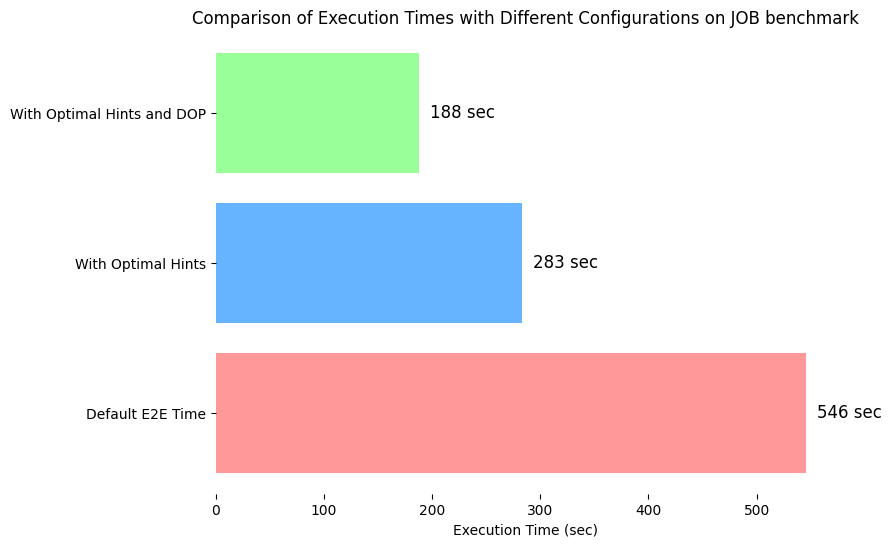

In [16]:
import matplotlib.pyplot as plt

labels = ['Default E2E Time', 'With Optimal Hints', 'With Optimal Hints and DOP']
times = [546, 283, 188]
colors = ['#ff9999','#66b3ff','#99ff99']

plt.figure(figsize=(8, 6))
bars = plt.barh(labels, times, color=colors)
for bar in bars:
    plt.text(bar.get_width() + 10, bar.get_y() + bar.get_height()/2, f'{int(bar.get_width())} sec', 
             va='center', ha='left', fontsize=12, color='black')

plt.xlabel('Execution Time (sec)')
plt.title('Comparison of Execution Times with Different Configurations on JOB benchmark')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

plt.show()

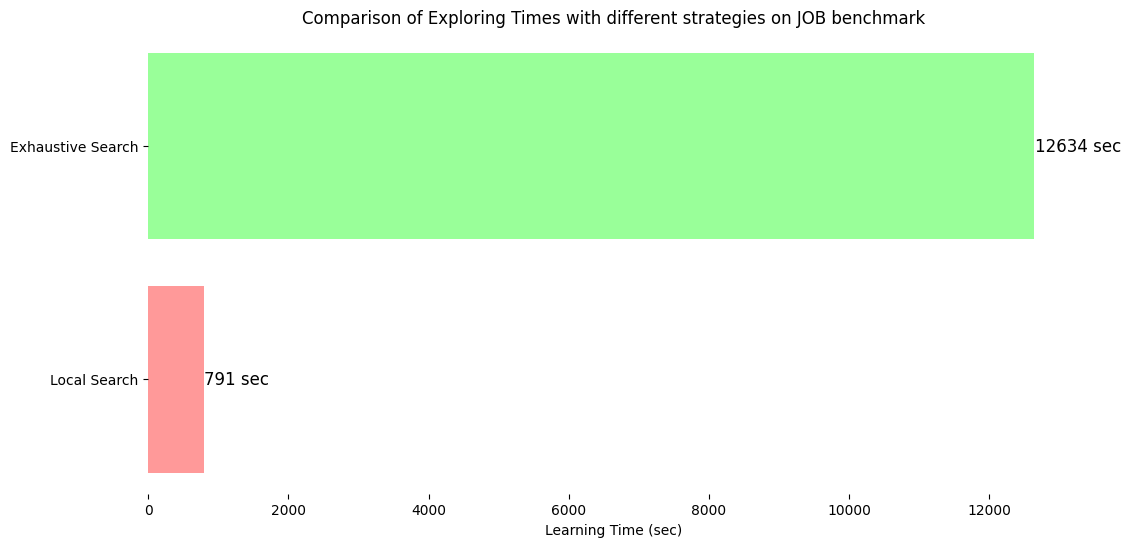

In [17]:
labels = ['Local Search', 'Exhaustive Search']
times = [791.7, 12634.7]
colors = ['#ff9999','#99ff99']

plt.figure(figsize=(12, 6))
bars = plt.barh(labels, times, color=colors)
for bar in bars:
    plt.text(bar.get_width() + 10, bar.get_y() + bar.get_height()/2, f'{int(bar.get_width())} sec', 
             va='center', ha='left', fontsize=12, color='black')

plt.xlabel('Learning Time (sec)')
plt.title('Comparison of Exploring Times with different strategies on JOB benchmark')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

plt.show()

You can see the **surprising** fact that the search space has grown, but the training time has even become shorter. The reason for this is that we find fast queries faster, which allows us to expose a more aggressive `timeout` and reduce resources for exploring bad queries.